In [2]:
#This is where the code can be downloaded from: https://github.com/fastai/imagenette

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
#from datasets import load_dataset
from tqdm import tqdm
import torchvision.models as models
# from torchvision.datasets import ImageNet
from torchvision.datasets import ImageFolder
# from fastai.vision.all import *
import matplotlib.pyplot as plt
#from fastai.vision.augment import Resize
from torch.utils.data import DataLoader
import numpy as np

import os

In [4]:
path = os.path.dirname(os.getcwd())
path += '/imagenette2-160/imagenette2-160'

In [5]:
# Define ImageNet normalization statistics
# imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Create common transformations for both training and validation
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats)
])

# Apply transformations directly to datasets
train_dataset = ImageFolder(root=os.path.join(path, 'train'), transform=common_transforms)
val_dataset = ImageFolder(root=os.path.join(path, 'val'), transform=common_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

In [6]:
for images, labels in train_loader:
    shape  = images.size()
    print(images.size())  # This will give you the size of the images batch
    break  # Exit after the first batch

torch.Size([64, 3, 224, 224])


In [7]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
num_classes = len(train_dataset.classes)
print(num_classes)

10


In [9]:
# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradients for faster inference
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [10]:
### ORIGINAL - NO CHANGES BESIDES LAST LAYER

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)

for param in model.fc.parameters():
  param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

model = model.to(device)

In [11]:
num_epochs = 10
train_loss_changed = np.zeros(num_epochs)
val_accuracy_changed = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_changed[epoch] = train(model, train_loader, criterion, optimizer, device)
    val_accuracy_changed[epoch] = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_changed[epoch]:.4f}, Val Accuracy: {val_accuracy_changed[epoch]:.4f}")

100%|██████████| 62/62 [00:02<00:00, 23.25it/s]


Epoch 1, Train Loss: 0.5119, Val Accuracy: 0.9605


100%|██████████| 62/62 [00:02<00:00, 23.08it/s]


Epoch 2, Train Loss: 0.1576, Val Accuracy: 0.9659


100%|██████████| 62/62 [00:02<00:00, 22.93it/s]


Epoch 3, Train Loss: 0.1223, Val Accuracy: 0.9689


100%|██████████| 62/62 [00:02<00:00, 22.83it/s]


Epoch 4, Train Loss: 0.0981, Val Accuracy: 0.9743


100%|██████████| 62/62 [00:02<00:00, 23.15it/s]


Epoch 5, Train Loss: 0.0886, Val Accuracy: 0.9755


100%|██████████| 62/62 [00:02<00:00, 23.61it/s]


Epoch 6, Train Loss: 0.0791, Val Accuracy: 0.9753


100%|██████████| 62/62 [00:02<00:00, 23.04it/s]


Epoch 7, Train Loss: 0.0700, Val Accuracy: 0.9727


100%|██████████| 62/62 [00:02<00:00, 24.05it/s]


Epoch 8, Train Loss: 0.0650, Val Accuracy: 0.9740


100%|██████████| 62/62 [00:02<00:00, 23.70it/s]


Epoch 9, Train Loss: 0.0613, Val Accuracy: 0.9771


100%|██████████| 62/62 [00:02<00:00, 23.43it/s]

Epoch 10, Train Loss: 0.0579, Val Accuracy: 0.9745


In [12]:
print(train_loss_changed)
print(val_accuracy_changed)

[0.51188205 0.15761169 0.12225144 0.09807804 0.08856276 0.07908382
 0.06997539 0.06495493 0.06134306 0.05794606]
[0.96050955 0.96585987 0.9689172  0.97426752 0.9755414  0.97528662
 0.97273885 0.97401274 0.97707006 0.97452229]


In [13]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model2 = model

# Freeze all parameters first
for param in model2.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer
new_layer = nn.Sequential(
     nn.ReLU(),
     nn.Linear(7, 7), #I changed this to nn.Linear(7,7) when unfreezing this particular layer
     nn.ReLU()
)
model2.layer4[1].conv2 = new_layer

model2.fc = nn.Linear(model.fc.in_features, num_classes)

# for param in model.layer4[1].conv2.parameters():
#     param.requires_grad = True

for param in model2.fc.parameters():
  param.requires_grad = True

for param in model2.layer4[1].conv2.parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
model2.to(device)

summary(model2, (3, 224, 224))
model2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
num_epochs = 10
train_loss_changed = np.zeros(num_epochs)
val_accuracy_changed = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_changed[epoch] = train(model2, train_loader, criterion, optimizer, device)
    val_accuracy_changed[epoch] = evaluate(model2, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_changed[epoch]:.4f}, Val Accuracy: {val_accuracy_changed[epoch]:.4f}")

100%|██████████| 62/62 [00:02<00:00, 22.75it/s]


Epoch 1, Train Loss: 1.7392, Val Accuracy: 0.9039


100%|██████████| 62/62 [00:02<00:00, 23.84it/s]


Epoch 2, Train Loss: 0.3084, Val Accuracy: 0.9480


100%|██████████| 62/62 [00:02<00:00, 23.69it/s]


Epoch 3, Train Loss: 0.1804, Val Accuracy: 0.9582


100%|██████████| 62/62 [00:02<00:00, 23.14it/s]


Epoch 4, Train Loss: 0.1388, Val Accuracy: 0.9641


100%|██████████| 62/62 [00:02<00:00, 23.62it/s]


Epoch 5, Train Loss: 0.1152, Val Accuracy: 0.9674


100%|██████████| 62/62 [00:02<00:00, 22.73it/s]


Epoch 6, Train Loss: 0.1011, Val Accuracy: 0.9674


100%|██████████| 62/62 [00:02<00:00, 23.61it/s]


Epoch 7, Train Loss: 0.0879, Val Accuracy: 0.9682


100%|██████████| 62/62 [00:02<00:00, 23.87it/s]


Epoch 8, Train Loss: 0.0812, Val Accuracy: 0.9707


100%|██████████| 62/62 [00:02<00:00, 23.78it/s]


Epoch 9, Train Loss: 0.0739, Val Accuracy: 0.9715


100%|██████████| 62/62 [00:02<00:00, 23.23it/s]

Epoch 10, Train Loss: 0.0683, Val Accuracy: 0.9707


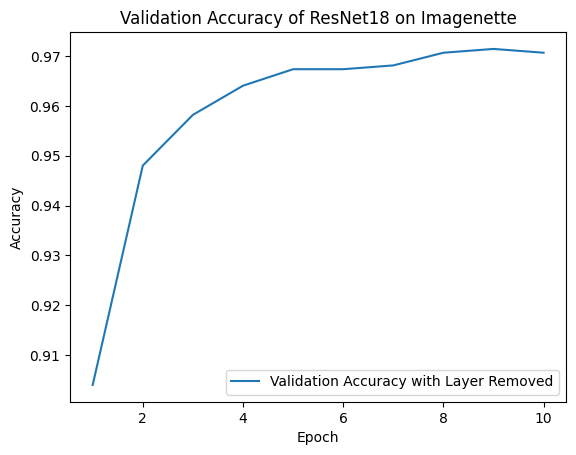

[0.90394904 0.94802548 0.95821656 0.96407643 0.96738854 0.96738854
 0.96815287 0.97070064 0.97146497 0.97070064]


In [16]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy_changed, label="Validation Accuracy with Layer Removed")
#plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of ResNet18 on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
print(val_accuracy_changed)
#print(val_accuracies)

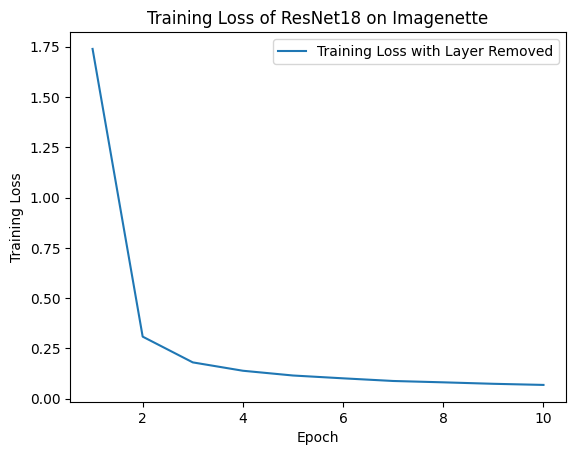

[1.73917727 0.30842882 0.18040805 0.13884195 0.11517303 0.10113398
 0.08792255 0.08120356 0.07391863 0.06833466]


In [17]:
plt.plot(epoch, train_loss_changed, label="Training Loss with Layer Removed")
#plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.title("Training Loss of ResNet18 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

print(train_loss_changed)
#print(train_losses)